# 1. Натренувати як мінімум 2 моделі кластеризації. Підібрати оптимальну кількість кластерів використовуючи як мінімум 2 метрики.

1. Скачуємо модель

In [ ]:
%%shell

DATASET_PATH="/content/SouthGermanCredit/"

if [ -d "$DATASET_PATH" ]
then
    echo "Dataset already installed at $DATASET_PATH"
else
    wget https://archive.ics.uci.edu/static/public/573/south+german+credit+update.zip
    unzip /content/south+german+credit+update.zip -d SouthGermanCredit
fi

--2024-08-22 08:16:25--  https://archive.ics.uci.edu/static/public/573/south+german+credit+update.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘south+german+credit+update.zip’

south+german+credit     [ <=>                ]  12.82K  --.-KB/s    in 0.03s   

2024-08-22 08:16:26 (467 KB/s) - ‘south+german+credit+update.zip’ saved [13130]

Archive:  /content/south+german+credit+update.zip
 bunzipping: SouthGermanCredit/codetable.txt  
 bunzipping: SouthGermanCredit/read_SouthGermanCredit.R  
 bunzipping: SouthGermanCredit/SouthGermanCredit.asc  


Скачуємо HDBScan

In [ ]:
%pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.2 MB/s eta 0:00:00


Імпортуємо всі необіхдні модулі та класи

In [ ]:
import numpy as np
import pandas as pd
import hdbscan
import sklearn
from sklearn import cluster, mixture, metrics, preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

Встановлюємо seed для рандому

In [ ]:
np.random.seed(17)

Зчитуємо ASC файл використовуючи `delimiter='  '`

In [ ]:
sgc = pd.read_table('/content/SouthGermanCredit/SouthGermanCredit.asc', delimiter=' ')

In [ ]:
sgc.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Check for NaN values

In [ ]:
any(sgc.isna().any().values)

False

Попередньо дивимося дані за допомогою алгоритму зменшення розмірностей tSNE.

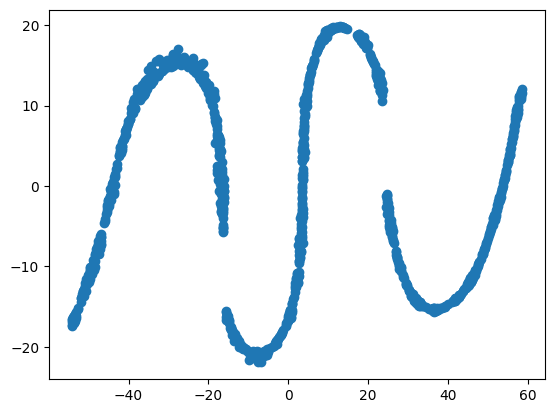

In [ ]:
tSNE = TSNE()
tsne_dp = tSNE.fit_transform(sgc)
plt.scatter(tsne_dp[:, 0], tsne_dp[:, 1])
plt.show()

На стиснених даних можна чітко побачити 3 кластери, проте дані для побудови tSNE не нормовані відносно один одного, тому може виникнути дизбаланс. Також стиснення у двовимірний простір не може відобразити реальної картини.

Далі використаємо трансформер, щоб нормалізувати дані. У ході експерименту було випробувано MinMax (приводить дані по всім класам у межі [0, 1]), нормальний (вичитує з даних середнє та ділить на дисперсію), та надійний (англ. Robust, нормалізує дані відносно квартилів). У фінальному результаті використовується MinMax, і всі подальші висновки зроблені з його використанням.

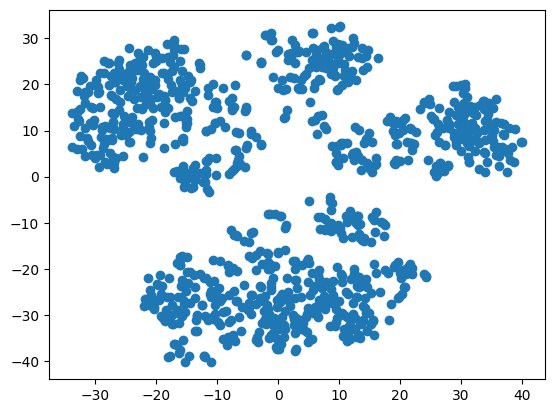

In [ ]:
transformer = preprocessing.MinMaxScaler()
# transformer = preprocessing.RobustScaler()
# transformer = preprocessing.NormalScaler()
sgc_norm = transformer.fit_transform(sgc)
tsne_sgc_norm = tSNE.fit_transform(sgc_norm)
plt.scatter(*tsne_sgc_norm.T)
plt.show()

З використанням алгоритму масштабування зображення, згенероване tSNE значно змінилось, а отже на нього нема чого орієнтуватися в подальшому.

Робимо обгортки для алгоритмів кластерування.

У даній роботі використовується 3 алгоритми:

1.   Mini batch Kmeans;
2.   HDBScan;
3.   Gaussian Mixure Model з Estimate-Maximize (EM) алгоритмом.

In [ ]:
def kmeans_wrapper(param, data):
    return cluster.MiniBatchKMeans(n_clusters=param, n_init="auto").fit_predict(data)


def hdbscan_wrapper(param, data):
    return hdbscan.HDBSCAN(min_cluster_size=int(data.shape[0] / (20 * param))).fit_predict(data)
    # return hdbscan.HDBSCAN(cluster_selection_epsilon=10 / param).fit_predict(data)


def gmm_wrapper(param, data):
    return mixture.GaussianMixture(n_components=param, covariance_type="full").fit_predict(data)

Декларуємо допоміжні константні структури та значення.

У якості метрик використовуємо:



1.   Сілует (чим більше значення, тим краща кластеризація);
2.   Девіса-Боулдіна (чим менше значення, тим краще кластеризація);
3.   Калінського-Гарабаша (чим більше значення, тим краща кластеризація).



In [ ]:
metrics_list = ["silhouette", "davies_bouldin", "calinski_harabasz"]
clusterging_algs = ["kmeans", "hdbscan", "gmm"]

metrics_func = {
    "silhouette"        : metrics.silhouette_score,
    "davies_bouldin"    : metrics.davies_bouldin_score,
    "calinski_harabasz" : metrics.calinski_harabasz_score,
}
cluster_func = {
    "kmeans"  : kmeans_wrapper,
    "hdbscan" : hdbscan_wrapper,
    "gmm"     : gmm_wrapper,
}
metrics_best_estimator = {
    "silhouette"        : np.max,
    "davies_bouldin"    : np.min,
    "calinski_harabasz" : np.max,
}
metrics_list.index("silhouette")
min_num_clusters = 2
max_num_clusters = 20

clustering_score = np.zeros(
    (len(clusterging_algs), len(metrics_list), max_num_clusters - min_num_clusters + 1)
)

Декларуємо функцію виміру метрик алгоритмів кластеризації датасету `dataset`. Функція проходиться по всім можливим кількостям кластерів у `cluster_size_limits = (min, max)` та для кожного алгоритму кластеризації у `cluster_funcs` оцінює надані метрики у `metrics_funcs`. Повертає на вихід 3-вимірний масив з метриками `(number_of_cluster_algs, number_of_metrics, number_of_clusters)`.

In [ ]:
def measure_clustering_performance(dataset, cluster_funcs, metrics_funcs, cluster_size_limits):
    min_num_clusters, max_num_clusters = cluster_size_limits
    clustering_score = np.zeros(
        (len(cluster_funcs), len(metrics_funcs), max_num_clusters - min_num_clusters + 1)
    )
    for n_clusters in range(min_num_clusters, max_num_clusters + 1):
        for cluster_func in cluster_funcs:
            labels = cluster_func(n_clusters, dataset)
            for metric in metrics_funcs:
                clustering_score[
                    cluster_funcs.index(cluster_func),
                    metrics_funcs.index(metric),
                    n_clusters - min_num_clusters
                ] = metric(dataset, labels)
    return clustering_score

In [ ]:
score = measure_clustering_performance(
    sgc_norm,
    list(cluster_func.values()),
    list(metrics_func.values()),
    (min_num_clusters, max_num_clusters)
)

Створюємо скрипт, що виводить на екран сітку графіків з підписами по вертикалі та горизонталі.

In [ ]:
def plot_cluster_precision(score, clusterging_algs, metrics_list, cluster_size_limits):
    min_num_clusters, max_num_clusters = cluster_size_limits
    fig, axes = plt.subplots(
        nrows=len(metrics_list),
        ncols=len(clusterging_algs),
        figsize=(16, 8)
    )

    for ax, col in zip(axes[0], clusterging_algs):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], metrics_list):
        ax.set_ylabel(row, rotation=90, size='large')

    for ax in axes.ravel():
        col, row = np.argwhere(axes.T == ax)[0]
        ax.plot(score[col, row, :], '-*')
        ax.set_xticks(
            ticks=np.arange(max_num_clusters - min_num_clusters + 1),
            labels=np.arange(min_num_clusters, max_num_clusters + 1)
        )
        ax.grid("on")

    fig.tight_layout()
    plt.show()

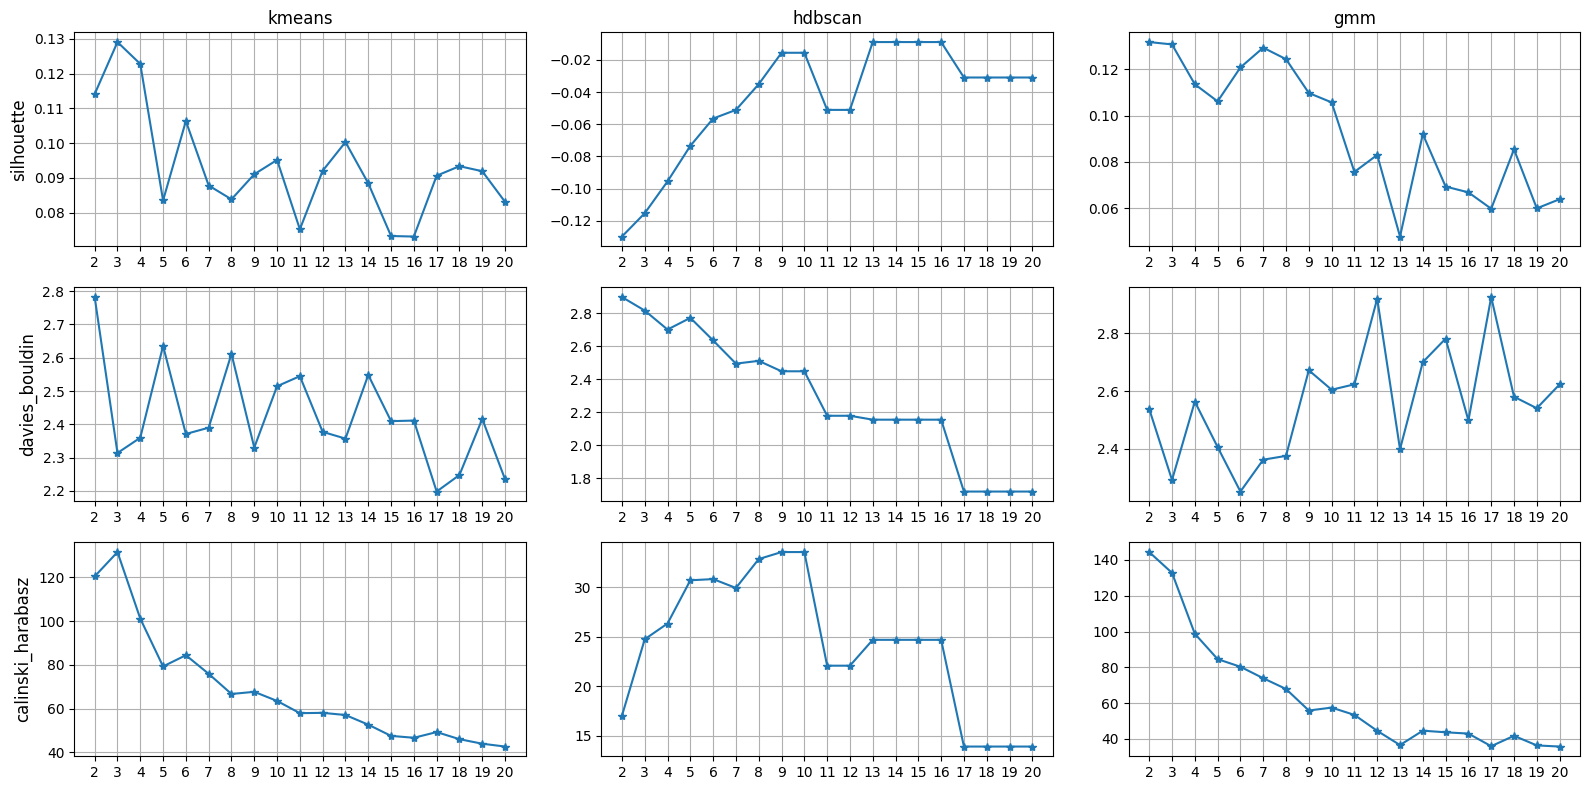

In [ ]:
plot_cluster_precision(score, clusterging_algs, metrics_list, (min_num_clusters, max_num_clusters))

З отриманих характеристик можна зробити висновок, що:

1. Для Kmeans, згідно з сілуетом та Калінського-Гарабаша, найкраща кількість кластерів становить 3. Згідно з Девіса-Боулдіна найкраща кількість кластерів становить 17, проте на 3-х кластерах результат також достатньо малий (локальний мінімум у діапазоні [2, 16]). Тому робимо висновок, що найкраща кількість кластерів для Kmeans = 3.

2. Хоча дана зміна параметру в HDBScan показала найкращий результат, проте сам результат кластеризації залишається незадовільним в порівнянні з іншими.

3. Модель суміщі гаусіан показала результат, аналогічний до Kmeans. Згідно з сілуетом та Калінського-Гарабаша, найкраща кількість кластерів становить 2. А згідно з Девіса-Боулдіна найкраща кількість кластерів становить 6.

Декларуємо допоміжну функцію, що визначатиме найкращі параметри та найкращі метрики. Результуючі масиви кортежа `best_params, best_scores` мають розмірність `(number_of_cluster_algs, number_of_metrics)`.

In [ ]:
def get_best_metric(clustering_score, metrics_compare_funcs, min_num_clusters):
    best_params = np.zeros(clustering_score.shape[0 : 2], dtype=int)
    best_scores = np.zeros(clustering_score.shape[0 : 2])
    for i in range(len(metrics_compare_funcs)):
        best_scores[:, i] = metrics_compare_funcs[i](clustering_score[:, i, :], axis=1)
        best_params[:, i] = np.argmax(
            clustering_score[:, i, :] == best_scores[:, i][:, np.newaxis],
            axis=1
        ) + min_num_clusters
    return best_params, best_scores

In [ ]:
opt_param, opt_score = get_best_metric(score, list(metrics_best_estimator.values()), min_num_clusters)

Транспонуємо вихідні матриці, щоб вони мали відповідність до виведених вище графіків.

In [ ]:
opt_param.T

array([[ 3, 13,  2],
       [17, 17,  6],
       [ 3,  9,  2]])

In [ ]:
opt_score.T

array([[ 1.29044606e-01, -8.95967004e-03,  1.31646310e-01],
       [ 2.19822061e+00,  1.71900893e+00,  2.25269681e+00],
       [ 1.31544737e+02,  3.35825068e+01,  1.44396533e+02]])

Як бачимо, виведені результати повністю співпадають з очікуваними з графіків.

# 2. Побудувати графік втрати інформації при зменшенні розмірності. Знайти оптимальну кількість кластерів і розбиття на кластери на перетворенному датасеті. Порівняти розбиття екземплярів на кластери для повного датасету і після втраті 30% інформації.

В якості параметра втрати інформації використовуємо суму відносних дисперсій по кожній компоненті.

In [ ]:
info_loss = np.array([
    PCA(sgc_norm.shape[1] - i).fit(sgc_norm).explained_variance_ratio_.sum()
    for i in np.arange(sgc_norm.shape[1])
])

Text(0.5, 1.0, 'Information loss for PCA')

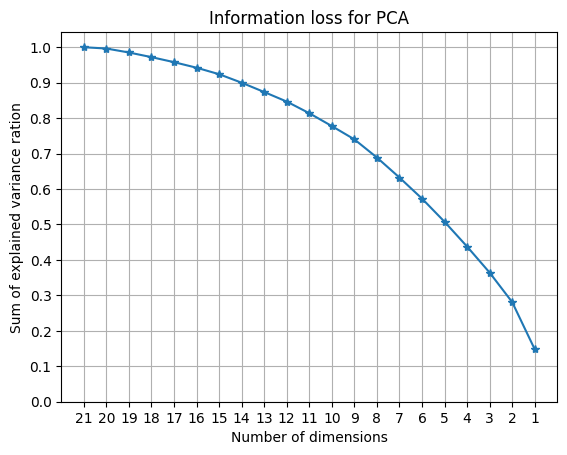

In [ ]:
plt.plot(info_loss,"-*")
plt.xticks(ticks=np.arange(info_loss.size), labels=np.arange(sgc_norm.shape[1], 0, -1))
plt.yticks(ticks=0.1 * np.arange(11))
plt.xlabel("Number of dimensions")
plt.ylabel("Sum of explained variance ration")
plt.grid("on")
plt.title("Information loss for PCA")

Спостерігаємо повільну втрату інформації логарифмічного характеру зі зменшенням кількості вимірів.

Заміримо для кожної зміни розмірності оптимальні параметри кластеризації та отримані метрики.

In [ ]:
best_params = np.zeros((len(cluster_func), len(metrics_func), sgc_norm.shape[1]), dtype=int)
best_scores = np.zeros((len(cluster_func), len(metrics_func), sgc_norm.shape[1]))

In [ ]:
for red_ndim in np.arange(sgc_norm.shape[1]):
    print(f"Number of dimensions to reduce: {red_ndim : < 2}")
    pca = PCA(sgc_norm.shape[1] - red_ndim)
    sgc_red = pca.fit_transform(sgc_norm)
    score = measure_clustering_performance(
        sgc_red,
        list(cluster_func.values()),
        list(metrics_func.values()),
        (min_num_clusters, max_num_clusters)
    )
    best_params[:, :, red_ndim], best_scores[:, :, red_ndim] = get_best_metric(
        score,
        list(metrics_best_estimator.values()),
        min_num_clusters
    )


Number of dimensions to reduce:  0
Number of dimensions to reduce:  1
Number of dimensions to reduce:  2
Number of dimensions to reduce:  3
Number of dimensions to reduce:  4
Number of dimensions to reduce:  5
Number of dimensions to reduce:  6
Number of dimensions to reduce:  7
Number of dimensions to reduce:  8
Number of dimensions to reduce:  9
Number of dimensions to reduce:  10
Number of dimensions to reduce:  11
Number of dimensions to reduce:  12
Number of dimensions to reduce:  13
Number of dimensions to reduce:  14
Number of dimensions to reduce:  15
Number of dimensions to reduce:  16
Number of dimensions to reduce:  17
Number of dimensions to reduce:  18
Number of dimensions to reduce:  19
Number of dimensions to reduce:  20


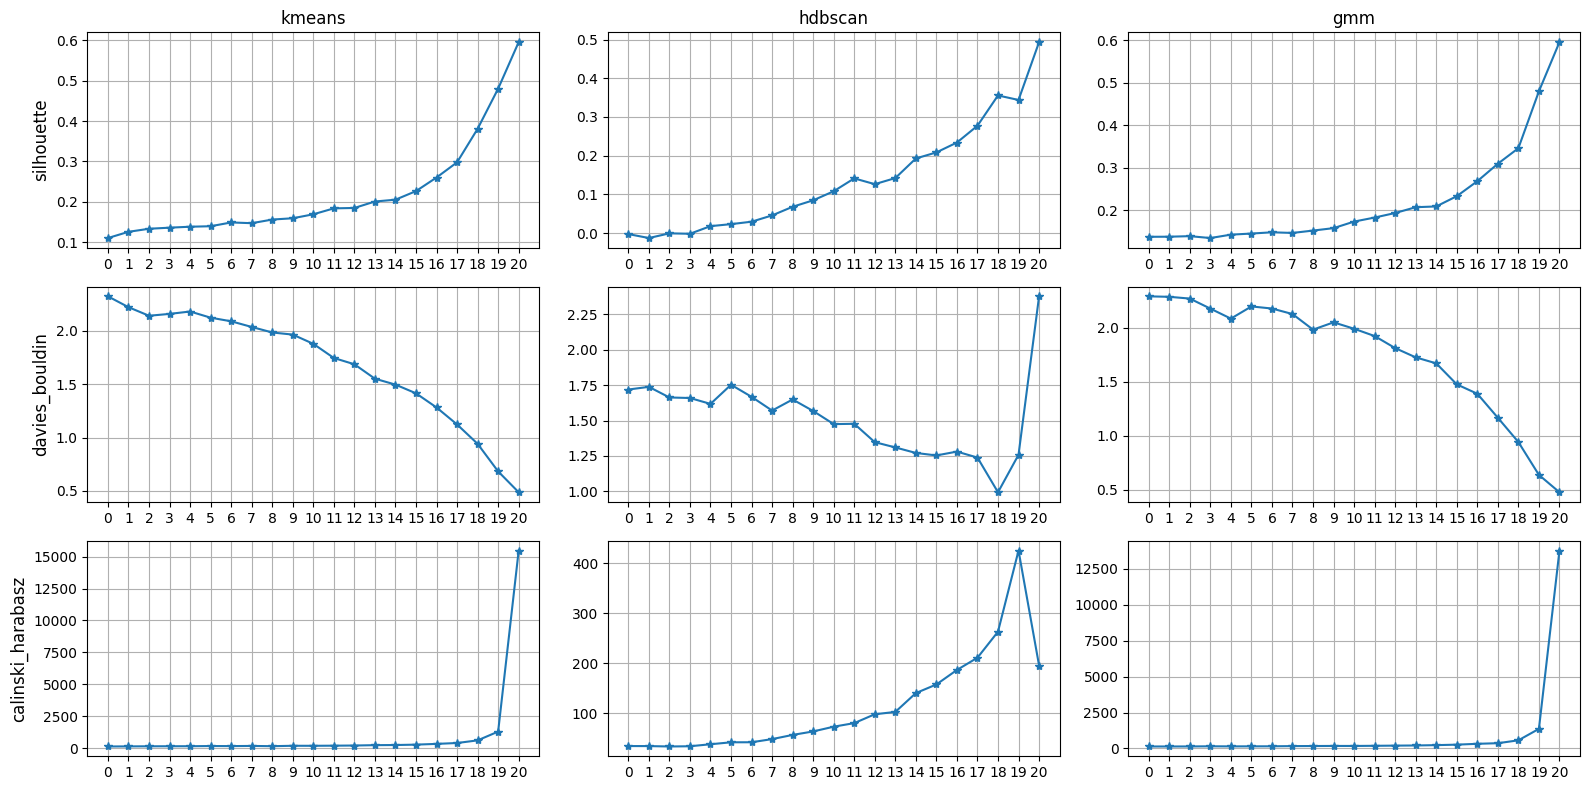

In [ ]:
plot_cluster_precision(best_scores, clusterging_algs, metrics_list, (0, sgc_norm.shape[1] - 1))

1. Для Kmeans, зі зменшенням розмірності якість оцінок підвищується. У випадку з метрикою Калінського-Гарабашу, метрика при стисненні датасету до одного виміру "улітає в космос".

2. Для HDBScan, аналогічна тенденція до Kmeans також спостерігається, проте для метрик Девіса-Болдуіна та Калінського-Гарабашу оцінка на одновимірному датасеті просідає.

3. Для GMM ситуація повністю аналогічна до Kmeans.

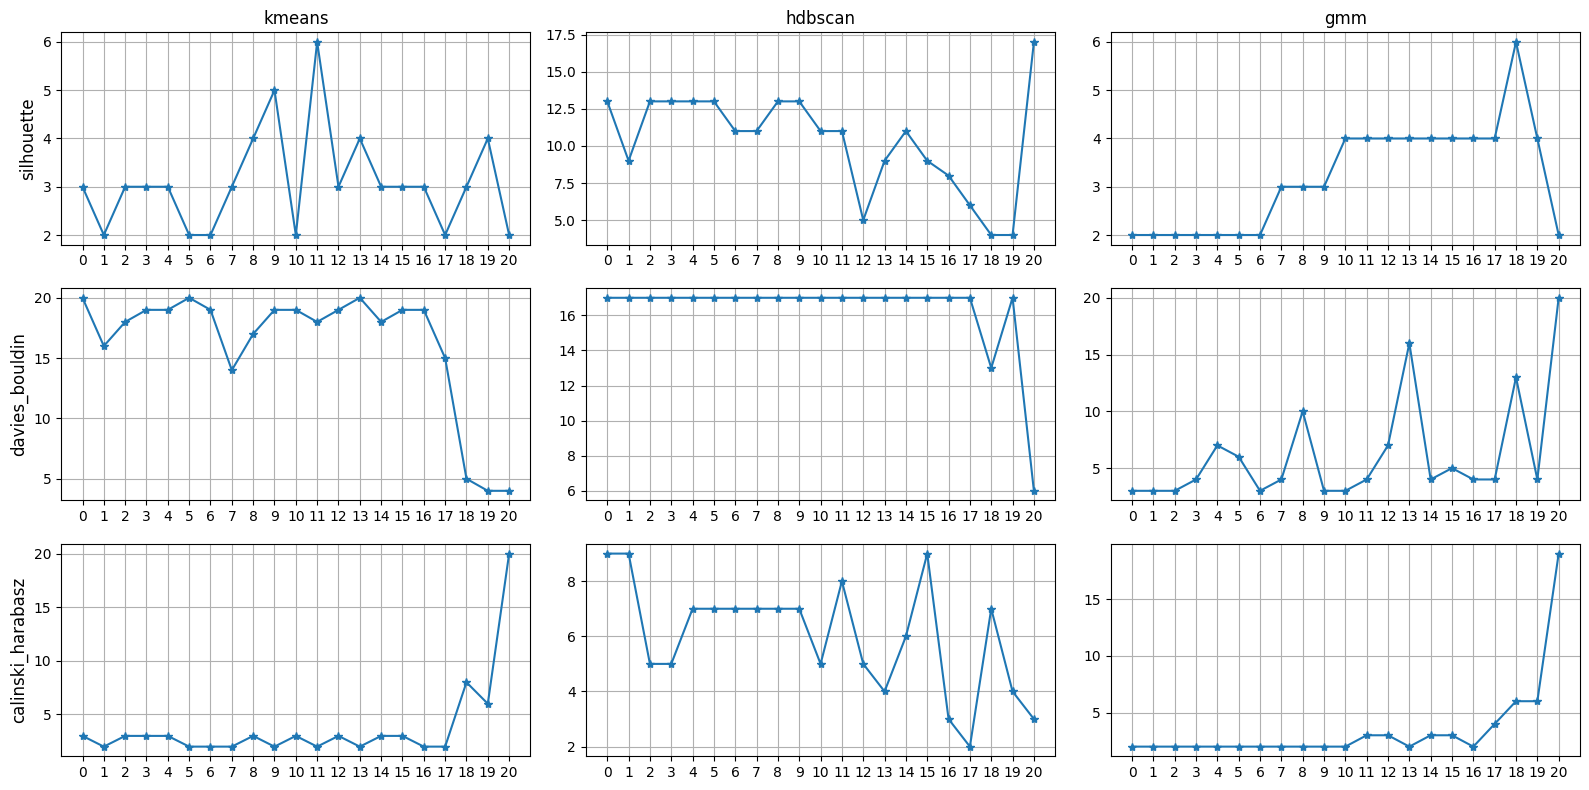

In [ ]:
plot_cluster_precision(best_params, clusterging_algs, metrics_list, (0, sgc_norm.shape[1] - 1))

Як видно з графіків, кількість кластерів аж ніяк не стала зі зміною розмірностей. Відносну стабільність продемонстрували: Kmeans з метрикою Калінського-Гарабаша, HDBScan з метрикою Девіса-Боулдіна, GMM з метриками сілуета та Калінського-Гарабаша.

Випадку з 30% втратою інформації відповідає кількість розмірностей 13. З графіків метрик бачимо, що в усіх випадках результат при стисненні розмірностей стає краще. Проте кількість кластерів залишається незмінною не у всіх випадках. Так, стабільність зберігається для:

* Kmeans з метриками Девіса-Боулдіна та Калінського-Гарабаша;
* HDBScan з метрикою Девіса-Боулдіна;
* GMM з метрикою Калінського-Гарабаша.

